# Телеком — описание задачи

Оператор связи «ТелеДом» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут **предложены** промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию DSL (от англ. *digital subscriber line —* «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic)*.

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### **Шаг 1. Загрузите данные и проведите исследовательский анализ данных**

In [1]:
!pip install skorch

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from skorch import NeuralNetClassifier
import torch.nn as nn
import torch
import torch.nn.functional as F
import numpy as np
import itertools
from sklearn.metrics import PrecisionRecallDisplay
from collections import defaultdict
import datetime
from sklearn.metrics import precision_recall_curve

In [3]:
db_config = {
    'user': 'user', # имя пользователя,
    'pwd': 'pwd', # пароль,
    'host': 'host',
    'port': 'port', # порт подключения,
    'db': 'db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

### Описание данных

Данные хранятся в таблицах в базе данных PostgreSQL:

- `contract` — информация о договоре,
- `personal` — персональные данные клиента,
- `internet` — информация об интернет-услугах,
- `phone` — информация об услугах телефонии.

In [4]:
engine = create_engine(connection_string)

In [5]:
query = '''
SELECT *
FROM telecom.contract
'''

contract  = pd.read_sql_query(query, con=engine)

In [6]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,None,Two year,Yes,Bank transfer (automatic),21.15,1419.40
7039,6840-RESVB,2019-02-26,None,One year,Yes,Mailed check,84.80,1990.50
7040,2234-XADUH,2019-09-02,None,One year,Yes,Credit card (automatic),103.20,7362.90
7041,4801-JZAZL,2019-06-26,None,Month-to-month,Yes,Electronic check,29.60,346.45


### **Таблица telecom.contract**

- `customerID` — ID пользователя,
- `BeginDate` — дата начала действия,
- `EndDate` — дата окончания действия,
- `Type` — тип оплаты (раз в год или помесячно),
- `PaperlessBilling` — безбумажный расчётный лист,
- `PaymentMethod` — тип платежа,
- `MonthlyCharges` — расход за месяц,
- `TotalCharges` — общие расходы.

In [7]:
query = '''
SELECT *
FROM telecom.personal
'''

personal  = pd.read_sql_query(query, con=engine)

In [8]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


### **Таблица personal**

- `customerID` — ID пользователя,
- `gender` — пол,
- `SeniorCitizen` — является ли абонент пенсионером,
- `Partner` — есть ли у абонента супруг/супруга,
- `Dependents` — есть ли у абонента дети.

In [9]:
query = '''
SELECT *
FROM telecom.internet
'''

internet  = pd.read_sql_query(query, con=engine)

In [10]:
internet.columns = internet.iloc[0]
internet = internet.drop(0)
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5513,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5514,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5515,4801-JZAZL,DSL,Yes,No,No,No,No,No
5516,8361-LTMKD,Fiber optic,No,No,No,No,No,No


### **Таблица telecom.internet**

- `customerID` — ID пользователя,
- `InternetService` — тип подключения,
- `OnlineSecurity` — блокировка небезопасных сайтов,
- `OnlineBackup` — облачное хранилище файлов для резервного копирования данных,
- `DeviceProtection` — антивирус,
- `TechSupport` — выделенная линия технической поддержки,
- `StreamingTV` — стриминговое телевидение,
- `StreamingMovies` — каталог фильмов.

In [11]:
query = '''
SELECT *
FROM telecom.phone
'''

phone  = pd.read_sql_query(query, con=engine)

In [12]:
phone.columns = phone.iloc[0]
phone = phone.drop(0)
phone

,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
...,...,...
6357,2569-WGERO,No
6358,6840-RESVB,Yes
6359,2234-XADUH,Yes
6360,8361-LTMKD,Yes


### **Таблица telecom.phone**

- `customerID` — ID пользователя,
- `MultipleLines` — подключение телефонного аппарата к нескольким линиям одновременно.

### **Шаг 2. Проведите исследовательский анализ данных**

#### Проанализируйте исходные данные на входе

    - Все ли таблицы имеют набор данных.
    - Соответствует ли количество таблиц условию задачи.
    - Имеется ли общий ключ для связи таблиц.

In [13]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [14]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [15]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 387.9+ KB


In [16]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 149.1+ KB


- Во всех таблицах есть данные,в `contract` есть пропуски.
- Количество таблиц соответствует условию задачи.
- Для связи таблиц есть общий ключ.

In [17]:
contract.TotalCharges = contract.TotalCharges.fillna(0)

#### Выделите целевую переменную на основе поля EndDate.

In [18]:
contract['churn'] = contract.EndDate.apply(lambda x: 1 if x else 0)
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,0.00,0
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,0.00,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,0.00,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


#### Сравните распределения величин ежемесячных платежей (MonthlyCharges) всех действующих клиентов и тех, кто ушёл. Для каждой группы посчитайте статистические показатели: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей. Постройте гистограммы распределения.

In [19]:
df_des = pd.DataFrame(contract.MonthlyCharges.describe()).merge(contract[contract.churn == 1].MonthlyCharges.describe(), left_index=True, right_index=True)
df_des.columns = ['all', 'churn']
df_des

,all,churn
count,7043.000000,1869.000000
mean,64.761692,74.441332
std,30.090047,24.666053
min,18.250000,18.850000
25%,35.500000,56.150000
50%,70.350000,79.650000
75%,89.850000,94.200000
max,118.750000,118.350000


В среднем и по квартилям у тех кто уходит ежемесячный платеж больше.

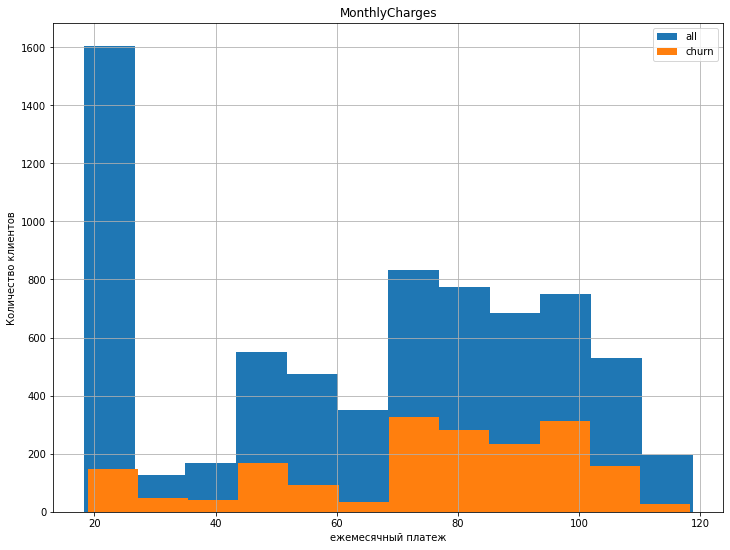

In [20]:
contract.MonthlyCharges.hist(bins=12)
contract[contract.churn == 1].MonthlyCharges.hist(bins=12,figsize=(12,9)).set_title('MonthlyCharges')
plt.xlabel('ежемесячный платеж')
plt.ylabel('Количество клиентов')
plt.legend(['all', 'churn']);

В основном те кто уходит платят ежемесячный платеж от 70 до 110.

#### Объединение всех датафреймов

In [21]:
full_df = contract.merge(personal, on='customerID').merge(internet, on='customerID', how='left').merge(phone, on='customerID', how='left')
full_df_copy = full_df.copy()
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
 8   churn             7043 non-null   int64  
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


После объединения появились пропуски заменим их на `unknown`

In [22]:
full_df.EndDate = full_df.EndDate.fillna(datetime.datetime.strptime('2020-02-01', "%Y-%m-%d").date())

In [23]:
full_df = full_df.fillna('unknown')
full_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,Female,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,unknown
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,0,Male,...,No,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.00,0,Female,...,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [24]:
full_df['ltv'] = (full_df[full_df.EndDate!='unknown'].EndDate - full_df[full_df.EndDate!='unknown'].BeginDate).apply(lambda x:x.days)
full_df

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ltv
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,Female,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,unknown,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,0,Male,...,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,479
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.00,0,Female,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,Fiber optic,No,No,No,No,No,No,No,279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,2569-WGERO,2019-01-21,2020-02-01,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0,Female,...,No,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,376
7039,6840-RESVB,2019-02-26,2020-02-01,One year,Yes,Mailed check,84.80,1990.50,0,Male,...,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,340
7040,2234-XADUH,2019-09-02,2020-02-01,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,...,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,152
7041,4801-JZAZL,2019-06-26,2020-02-01,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,...,Yes,DSL,Yes,No,No,No,No,No,unknown,220


In [25]:
full_df = full_df.fillna(0)
full_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,churn,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ltv
0,4472-LVYGI,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.55,0.00,0,Female,...,Yes,DSL,Yes,No,Yes,Yes,Yes,No,unknown,0
1,3115-CZMZD,2020-02-01,2020-02-01,Two year,No,Mailed check,20.25,0.00,0,Male,...,Yes,unknown,unknown,unknown,unknown,unknown,unknown,unknown,No,0
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,479
3,5709-LVOEQ,2020-02-01,2020-02-01,Two year,No,Mailed check,80.85,0.00,0,Female,...,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,Fiber optic,No,No,No,No,No,No,No,279


In [26]:
X_train, X_test, y_train, y_test = train_test_split(full_df.drop(['customerID', 'BeginDate',
                                                                  'EndDate','churn'], axis=1), full_df['churn'], test_size=0.2)

In [27]:
d = defaultdict(LabelEncoder)

In [28]:
X_train[X_train.select_dtypes('object').columns] = X_train[X_train.select_dtypes('object')\
                                                           .columns].apply(lambda x: d[x.name].fit_transform(x))

In [29]:
X_test[X_test.select_dtypes('object').columns] = X_test[X_test.select_dtypes('object')\
                                                        .columns].apply(lambda x: d[x.name].transform(x))

### **Шаг 3. Обучите модель**

Найдите лучшую модель прогнозирования оттока. За критерий оценки качества модели возьмите метрику ROC-AUC. Значение метрики должно быть не менее 0.78. Для интерпретируемости модели дополнительно выведите значение accuracy каждой модели. Рассмотрите следующие классы моделей:

- решающее дерево

In [30]:
pipe_rf = Pipeline([('standard', StandardScaler()),
                     ('model', RandomForestClassifier(random_state=42))])
grid_params_rf = [{'model__max_depth' :[3, 5, 7, 9],
                    'model__min_samples_leaf': [1, 2, 3]}]

In [31]:
jobs = -1

rf = GridSearchCV(estimator=pipe_rf,
                   param_grid=grid_params_rf,
                   scoring='roc_auc',
                   cv=5,
                   n_jobs=jobs)

In [32]:
rf.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard', StandardScaler()),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'model__max_depth': [3, 5, 7, 9],
                          'model__min_samples_leaf': [1, 2, 3]}],
             scoring='roc_auc')

In [33]:
rf_predict = rf.predict(X_test)
rf_as = accuracy_score(y_test, rf_predict)
(rf.best_params_, rf.best_score_)

({'model__max_depth': 7, 'model__min_samples_leaf': 3}, 0.844047721047955)

- бустинги

In [34]:
pipe_cb = Pipeline([('standard', StandardScaler()),
                    ('model', CatBoostClassifier(verbose = 200, random_state=42))])
grid_params_cb = [{'model__n_estimators' :[200, 400, 600],
                   'model__learning_rate': [.03, .1],
                   }]

In [35]:
jobs = -1

cb = GridSearchCV(estimator=pipe_cb,
                  param_grid=grid_params_cb,
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=jobs)

In [36]:
cb.fit(X_train, y_train)

0:	learn: 0.6726787	total: 48.9ms	remaining: 9.74s
199:	learn: 0.3627449	total: 485ms	remaining: 0us
0:	learn: 0.6726576	total: 2.07ms	remaining: 412ms
199:	learn: 0.3620096	total: 511ms	remaining: 0us
0:	learn: 0.6722618	total: 1.91ms	remaining: 379ms
199:	learn: 0.3664861	total: 449ms	remaining: 0us
0:	learn: 0.6730547	total: 1.93ms	remaining: 385ms
199:	learn: 0.3649281	total: 446ms	remaining: 0us
0:	learn: 0.6729222	total: 1.86ms	remaining: 370ms
199:	learn: 0.3607197	total: 438ms	remaining: 0us
0:	learn: 0.6726787	total: 2.77ms	remaining: 1.11s
200:	learn: 0.3625435	total: 470ms	remaining: 465ms
399:	learn: 0.3207523	total: 884ms	remaining: 0us
0:	learn: 0.6726576	total: 2.17ms	remaining: 865ms
200:	learn: 0.3617391	total: 455ms	remaining: 451ms
399:	learn: 0.3204566	total: 936ms	remaining: 0us
0:	learn: 0.6722618	total: 2.1ms	remaining: 839ms
200:	learn: 0.3663858	total: 454ms	remaining: 450ms
399:	learn: 0.3228135	total: 878ms	remaining: 0us
0:	learn: 0.6730547	total: 2.75ms	rem

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard', StandardScaler()),
                                       ('model',
                                        <catboost.core.CatBoostClassifier object at 0x7f58bc070b80>)]),
             n_jobs=-1,
             param_grid=[{'model__learning_rate': [0.03, 0.1],
                          'model__n_estimators': [200, 400, 600]}],
             scoring='roc_auc')

In [37]:
(cb.best_params_, cb.best_score_)

({'model__learning_rate': 0.03, 'model__n_estimators': 200}, 0.846959278530961)

In [38]:
cat_model = CatBoostClassifier(learning_rate = cb.best_params_["model__learning_rate"],
                               n_estimators  = cb.best_params_["model__n_estimators"],
                               verbose       = 200)

In [39]:
cat_model.fit(X_train,
              y_train)
cb_predict = cat_model.predict(X_test)
cb_as = accuracy_score(y_test, cb_predict)

0:	learn: 0.6731871	total: 2.52ms	remaining: 502ms
199:	learn: 0.3696842	total: 507ms	remaining: 0us


- нейронные сети.

In [40]:
class MyModule(nn.Module):
    def __init__(self, num_units=15, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(18, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 12)
        self.dense2 = nn.Linear(12, 6)
        self.output = nn.Linear(6, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = torch.tanh(self.dense1(X))
        X = torch.relu(self.dense2(X))
        X = F.softmax(self.output(X),dim=1)
        return X

In [41]:
pipe_net = Pipeline([('standard', StandardScaler()),
                    ('model', NeuralNetClassifier(MyModule, max_epochs=30, iterator_train__shuffle=True))])
grid_params_net = [{'model__lr' :[0.01, .05],
                   'model__module__num_units': [50, 150],}]

In [42]:
jobs = -1

net = GridSearchCV(estimator=pipe_net,
                  param_grid=grid_params_net,
                  scoring='roc_auc',
                  cv=5,
                  n_jobs=jobs)

In [43]:
net.fit(X_train.values.astype(np.float32), y_train.values.astype(np.int64))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7052       0.7162        0.6811  0.2419
      2        0.6621       0.7328        0.6448  0.3101
      3        0.6311       0.7328        0.6186  0.2982
      4        0.6102       0.7328        0.6004  0.2893
      5        0.5943       0.7328        0.5872  0.3066
      6        0.5834       0.7328        0.5777  0.2875
      7        0.5768       0.7328        0.5705  0.3022
      8        0.5708       0.7328        0.5647  0.2944
      9        0.5645       0.7328        0.5599  0.2986
     10        0.5599       0.7328        0.5558  0.2961
     11        0.5558       0.7328        0.5517  0.2930
     12        0.5537       0.7328        0.5478  0.2956
     13        0.5501       0.7328        0.5438  0.2884
     14        0.5453       0.7328        0.5398  0.2996
     15        0.5442       0.7328        0.5359  0.3047
     16        0.5390       0.7

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standard', StandardScaler()),
                                       ('model',
                                        <class 'skorch.classifier.NeuralNetClassifier'>[uninitialized](
  module=<class '__main__.MyModule'>,
))]),
             n_jobs=-1,
             param_grid=[{'model__lr': [0.01, 0.05],
                          'model__module__num_units': [50, 150]}],
             scoring='roc_auc')

In [44]:
print(net.best_score_, net.best_params_)

0.8376315852919178 {'model__lr': 0.05, 'model__module__num_units': 150}


In [45]:
net_predict = net.predict(X_test.values.astype(np.float32))

Лучше всего метрика у CatBoostClassifier  ROC-AUC = 0.8484419523810638

In [46]:
accuracy = pd.DataFrame({
    'решающее дерево': [rf_as],
    'бустинги': [cb_as],
    'нейронка': [accuracy_score(y_test, net_predict)]})
accuracy.index = ['accuracy']
accuracy

,решающее дерево,бустинги,нейронка
accuracy,0.800568,0.799858,0.7956


 ### **Шаг 4.  Тестирование модели и демонстрация ее работы**

- Проведите графический анализ «Матрица ошибок». Выведите полноту и точность на график.

Confusion matrix, without normalization
[[946  97]
 [185 181]]


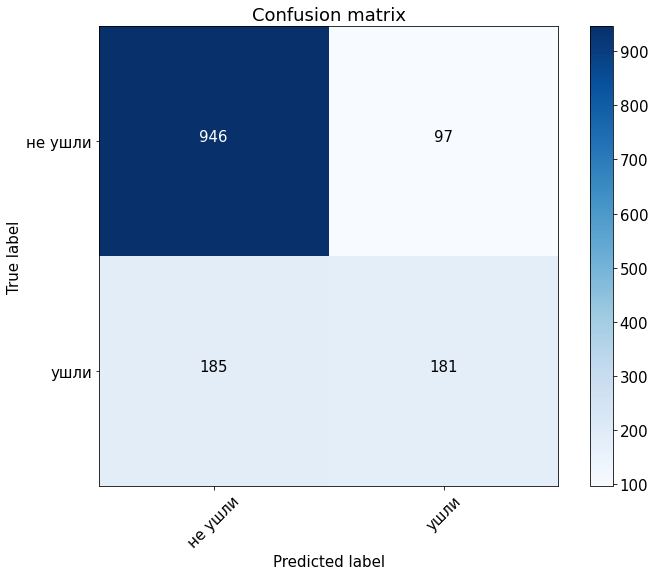

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, cb_predict)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['не ушли', 'ушли'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

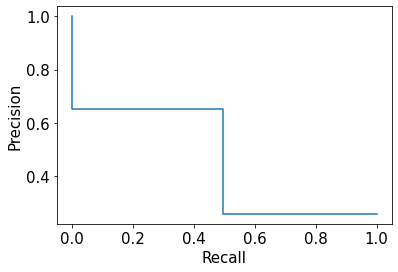

In [48]:
precision, recall, _ = precision_recall_curve(y_test, cb_predict)
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot();

- Проанализируйте важность основных факторов, влияющих на отток клиента.

In [49]:
df = pd.DataFrame((cat_model.feature_importances_)).T
df.columns = X_train.columns
df.T.sort_values(0,ascending=0)

,0
Type,19.361690
TotalCharges,17.211836
OnlineSecurity,6.869624
InternetService,6.836953
MonthlyCharges,6.833098
ltv,6.505766
PaymentMethod,6.181256
TechSupport,4.378694
StreamingMovies,4.243240
PaperlessBilling,3.878605


-  Для одного из выявленных важных факторов проведите дополнительное исследование:

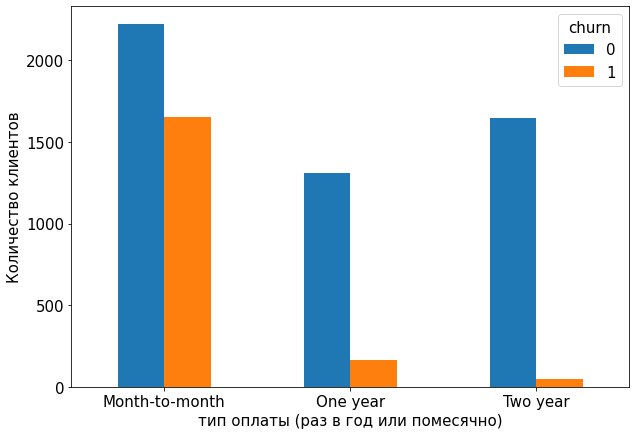

In [50]:
pd.crosstab(full_df_copy['Type'],full_df_copy['churn']).plot(kind='bar',figsize=(10,7))
plt.xlabel('тип оплаты (раз в год или помесячно)')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0)
plt.show()

Клиенты которые платят помесячно чаще всего уходят.

## Вывод
- Во всех таблицах есть данные, в `contract` есть пропуски, которые заменены на `unknown`.
- Количество таблиц соответствует условию задачи.
- Для связи таблиц есть общий ключ.
- В среднем и по квартилям у тех кто уходит ежемесячный платеж больше.
- В основном те кто уходит платят ежемесячный платеж от 70 до 110.
- Использованны модели RandomForestClassifier, CatBoostClassifier и NeuralNetClassifier.
- Удалось достичь критерий оценки качества ROC-AUC не менее 0.78.
- Лучше всего метрика у CatBoostClassifier ROC-AUC = 0.8484419523810638.
- Клиенты которые платят помесячно чаще всего уходят.
- Для удержания клиентов есть смысл пересмотреть цены на помесячную оплату.